# CNN + GlobalAvgPool
Derived from notebook LSTM 132. 
Combined cell lines. Coding RNA up to 4K. 

Notebook 144 would die on CoLab due to a memory leak in keras.model.fit().
We tried releasing every bit of memory we could, including X_valid. 
Still died.

Here, we implemented this pathetic work-around of calling the garbage collector. 
It worked.
https://github.com/tensorflow/tensorflow/issues/37505

The results are impressive.      
 accuracy mean 75.35% +/- 0.88  
 precision mean 76.21% +/- 0.86  
 recall mean 97.63% +/- 0.62  
 F1 mean 85.60% +/- 0.67   

In [12]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2023-01-18 22:45:33.291157
Python 3.8.10
sklearn 1.0.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [13]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
RCI_THRESHOLD=0.0
CFILTERS=64
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=3
FOLDS=5      
EMBED_DIMEN = 4 # arbitrary hyperparameter
BREAK = False   # break after first fold
MINLEN=200
MAXLEN=4000   

In [14]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/


In [15]:
GENES_FILE =    'CNRCI_coding_train_genes.csv'
RCI_FILE =      'CNRCI_coding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_coding_train_transcripts.gc42.csv'
COUNTS_FILE=    'CNRCI_coding_train_counts.K4.gc42.csv'

In [16]:
def get_ordered_list():
    ordered_list = \
    ['A549',\
      'H1.hESC',\
      'HeLa.S3',\
      'HepG2',\
      'HT1080',\
      'HUVEC',\
      'MCF.7',\
      'NCI.H460',\
      'NHEK',\
      'SK.MEL.5',\
      'SK.N.DZ',\
      'SK.N.SH',\
      'GM12878',\
      'K562',\
      'IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()
EXCLUSIONS = [1,7]
for c in EXCLUSIONS:
    print('Exclude cell line',c,all_cell_lines[c])

Exclude cell line 1 H1.hESC
Exclude cell line 7 NCI.H460


## Data Load

In [17]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,exclusions=[]):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        overall_sum = 0
        overall_count = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    rci_max = None
                    rci_count = 0
                    cell_line = 0 # first line is 0 = A549
                    for rci_str in fields:
                        if rci_str != "nan" and cell_line not in exclusions:
                            rci_val = float(rci_str)
                            if rci_max is None or rci_val > rci_max:
                                rci_max = rci_val
                            rci_count += 1
                        cell_line += 1   
                    if rci_count > 0:
                        gene_to_rci[gene_id] = rci_max
                        overall_sum += rci_max
                        overall_count += 1
        overall_mean = overall_sum / overall_count
        print('Number of RCI values',overall_count)
        print('Mean RCI value',overall_mean)
        return gene_to_rci
    
    def seq_to_kmer_values(self,rna,K):
        # The cache may represent more than one K. Probably not a problem.
        N_indicator = 0 # indicator value
        vec=[] # seq converted to list of K-mers 
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def rci_to_label(self,rci):
        CYTO_LABEL = 1
        NUCLEAR_LABEL = 0
        # cnrci = log (cyto-to-nuclear ratio)
        # rci > 0 implies cytoplasmic
        if rci > RCI_THRESHOLD:
            return CYTO_LABEL
        return NUCLEAR_LABEL

    def load_sequence(self,filepath):
        labels=[]
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        rci_val = gene_to_rci[gene_id]
                        rci_label = self.rci_to_label(rci_val)
                        labels.append(rci_label)
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        return labels,allids,allseq
    
loader = DataLoader()
# test it
print(loader.seq_to_kmer_values('AAAA',3))
print(loader.seq_to_kmer_values('CATT',3))
print(loader.seq_to_kmer_values('TTGA',3))
print(loader.seq_to_kmer_values('TTTN',3))
# test it
print(loader.rci_to_label(-0.9))
print(loader.rci_to_label(1.1))

[1, 1]
[20, 16]
[63, 57]
[64, 0]
0
1


In [18]:
print(datetime.now())
print("Load RCI values...")
loader = DataLoader()
filepath = DATA_DIR+RCI_FILE
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
print('Example RCI:', list(gene_to_rci.items())[:3])
print("Load genes...")
all_genes = list(gene_to_rci.keys())
print(datetime.now())
print('Load sequence...')
filepath = DATA_DIR+SEQUENCE_FILE
labels,allids,allseq = loader.load_sequence(filepath)
print(datetime.now())
print('Num IDs:',len(allids))
print('Example IDs:',[allids[x] for x in [10, 20, 30, 40]] )
print('Count',np.count_nonzero(labels),'ones out of',len(labels),'labels.')
print('Num labels:',len(labels))
print('Example labels:',[labels[x] for x in [10, 20, 30, 40]] )
print('Num sequences:',len(allseq))
print('Example sequence:',allseq[3])
loader = None  # drop K-mer cache to save RAM

2023-01-18 22:45:34.825571
Load RCI values...
Number of RCI values 13512
Mean RCI value 0.742330935725574
Num RCI: 13512
Example RCI: [('ENSG00000000003', 2.29436), ('ENSG00000000419', 2.1946), ('ENSG00000000457', 0.434284)]
Load genes...
2023-01-18 22:45:34.911171
Load sequence...
2023-01-18 22:46:38.195037
Num IDs: 54410
Example IDs: [('ENSG00000187634', 'ENST00000455979.1'), ('ENSG00000187608', 'ENST00000624652.1'), ('ENSG00000131591', 'ENST00000427787.5'), ('ENSG00000186827', 'ENST00000699969.1')]
Count 40851 ones out of 54410 labels.
Num labels: 54410
Example labels: [0, 1, 0, 0]
Num sequences: 54410
Example sequence: [147, 73, 35, 138, 38, 150, 85, 83, 74, 37, 147, 73, 36, 142, 54, 214, 88, 95, 122, 231, 155, 106, 167, 156, 112, 190, 247, 218, 103, 153, 99, 139, 43, 172, 175, 187, 235, 169, 162, 135, 27, 107, 169, 161, 131, 10, 39, 155, 107, 170, 168, 159, 123, 235, 169, 161, 131, 12, 46, 183, 219, 107, 170, 166, 151, 89, 99, 139, 43, 169, 161, 129, 1, 3, 12, 46, 184, 223, 121, 2

## Model

In [19]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool_layer = GlobalAveragePooling1D()
    flat_layer = Flatten()
    den1_layer = Dense(DCELLS)
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    cnn.add(pool_layer)
    cnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    print("COMPILE")
    cnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return cnn

In [20]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-01-18 22:46:38.228689
COMPILE
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 3997, 4)           1028      
                                                                 
 conv1d_6 (Conv1D)           (None, 3990, 64)          2112      
                                                                 
 global_average_pooling1d_6   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 3,205
Trainable params: 3,205
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [21]:
import gc
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.threshold = threshold
    
    def get_gene_subset(self,all_genes,sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes
    
    def get_X_y(self,gene_set,allids,allX,allY):
        cnt = len(allids)
        subsetX=[]
        subsetY=[]
        if cnt != len(allX) or cnt!= len(allY):
            raise Exception('Lengths differ')
        for i in range(cnt):
            gene_id,tran_id = allids[i]
            if gene_id in gene_set:
                oneX = allX[i]
                oneY = allY[i]
                subsetX.append(oneX)
                subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def do_cross_validation(self):
        cv_accuracy=[]
        cv_precision=[]
        cv_recall=[]
        cv_f1=[]
        fold=0
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True,random_state=42)
        splits = splitter.split(all_genes)
        splitter = None
        for train_index,valid_index in splits:
            fold += 1
            print('Fold',fold)
            train_genes = self.get_gene_subset(all_genes,train_index)
            X_train,y_train = self.get_X_y(train_genes,allids,allseq,labels)

            print('Training example')
            print(X_train[0])

            print("BUILD MODEL")
            model=build_model()

            print("FIT")
            # There is a memory leak within the fit() command!
            # Each successive call to fit() consumes more memory.
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                    epochs=self.epochs, verbose=1)  # verbose=1 for ascii art, verbose=0 for none
                    # validation_data=(X_valid,y_valid) )
            print(datetime.now())
            tf.keras.backend.clear_session()
            gc.collect()

            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()

            print('Train sizes',X_train.shape,y_train.shape)
            print('Train set ones/size',
                  np.count_nonzero(y_train),'/',len(y_train))
            X_train = None
            y_train = None
            train_genes = None

            print("Compute valiation accuracy")
            print(datetime.now())
            valid_genes = self.get_gene_subset(all_genes,valid_index)
            X_valid,y_valid = self.get_X_y(valid_genes,allids,allseq,labels)
            print('Valid sizes',X_valid.shape,y_valid.shape)
            print('Valid set ones/size',
                  np.count_nonzero(y_valid),'/',len(y_valid))
            yhat_pred=model.predict(X_valid, verbose=0) 
            print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
            yhat_classes=np.where(yhat_pred > self.threshold, 1, 0)
            print('Predicted zeros and ones',np.count_nonzero(yhat_classes==0),np.count_nonzero(yhat_classes==1))
            # accuracy: (tp + tn) / (p + n)
            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            # precision tp / (tp + fp)
            precision = precision_score(y_valid, yhat_classes)*100.
            # recall: tp / (tp + fn)
            recall = recall_score(y_valid, yhat_classes)*100.
            # f1: 2 tp / (2 tp + fp + fn)
            f1 = f1_score(y_valid, yhat_classes)*100.
            yhat_classes = None
            X_valid = None
            y_valid = None
            valid_genes = None
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%% F1: %.2f%%' % (accuracy,precision,recall,f1)) 
            print(datetime.now())
            cv_accuracy.append(accuracy)
            cv_precision.append(precision)
            cv_recall.append(recall)
            cv_f1.append(f1)
            model = None
            history = None
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break
        print()
        return cv_accuracy, cv_precision, cv_recall, cv_f1

2023-01-18 22:46:38.680624
2023-01-18 22:46:38.680763
splitting
Fold 1
Training example
[167 155 106 ...   0   0   0]
BUILD MODEL
COMPILE
FIT
2023-01-18 22:46:49.243669
Epoch 1/3
1356/1356 [==============================] - 9s 6ms/step - loss: 0.5486 - accuracy: 0.7487
Epoch 2/3
1356/1356 [==============================] - 8s 6ms/step - loss: 0.5410 - accuracy: 0.7518
Epoch 3/3
1356/1356 [==============================] - 8s 6ms/step - loss: 0.5386 - accuracy: 0.7535
2023-01-18 22:47:32.355290


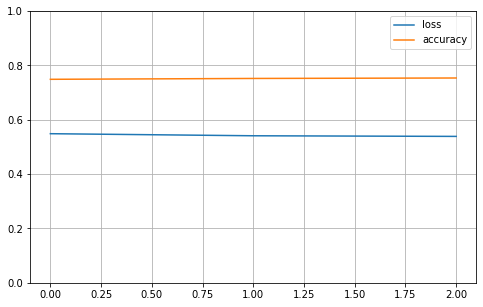

Train sizes (43381, 3997) (43381, 1)
Train set ones/size 32398 / 43381
Compute valiation accuracy
2023-01-18 22:47:33.661862
Valid sizes (11029, 3997) (11029, 1)
Valid set ones/size 8453 / 11029
Range of scores: 0.13737136 to 0.96297187
Predicted zeros and ones 288 10741
Accuracy: 76.75% Precision: 77.41% Recall: 98.37% F1: 86.64%
2023-01-18 22:47:36.895631
Fold 2
Training example
[167 155 106 ...   0   0   0]
BUILD MODEL
COMPILE
FIT
2023-01-18 22:47:45.717242
Epoch 1/3
1358/1358 [==============================] - 9s 6ms/step - loss: 0.5474 - accuracy: 0.7518
Epoch 2/3
1358/1358 [==============================] - 8s 6ms/step - loss: 0.5390 - accuracy: 0.7548
Epoch 3/3
1358/1358 [==============================] - 8s 6ms/step - loss: 0.5367 - accuracy: 0.7555
2023-01-18 22:48:28.466863


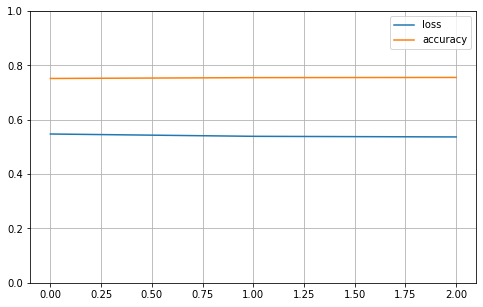

Train sizes (43433, 3997) (43433, 1)
Train set ones/size 32532 / 43433
Compute valiation accuracy
2023-01-18 22:48:29.732930
Valid sizes (10977, 3997) (10977, 1)
Valid set ones/size 8319 / 10977
Range of scores: 0.22530016 to 0.98072207
Predicted zeros and ones 386 10591
Accuracy: 75.53% Precision: 76.59% Recall: 97.51% F1: 85.80%
2023-01-18 22:48:33.626714
Fold 3
Training example
[167 155 106 ...   0   0   0]
BUILD MODEL
COMPILE
FIT
2023-01-18 22:48:42.304525
Epoch 1/3
1354/1354 [==============================] - 9s 6ms/step - loss: 0.5454 - accuracy: 0.7516
Epoch 2/3
1354/1354 [==============================] - 9s 7ms/step - loss: 0.5379 - accuracy: 0.7538
Epoch 3/3
1354/1354 [==============================] - 9s 7ms/step - loss: 0.5355 - accuracy: 0.7548
2023-01-18 22:49:25.128026


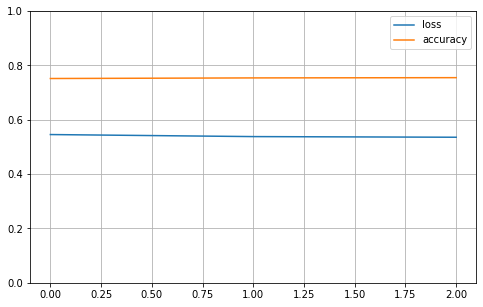

Train sizes (43311, 3997) (43311, 1)
Train set ones/size 32481 / 43311
Compute valiation accuracy
2023-01-18 22:49:26.387510
Valid sizes (11099, 3997) (11099, 1)
Valid set ones/size 8370 / 11099
Range of scores: 0.21262088 to 0.9644579
Predicted zeros and ones 469 10630
Accuracy: 75.57% Precision: 76.61% Recall: 97.30% F1: 85.73%
2023-01-18 22:49:30.380021
Fold 4
Training example
[167 155 106 ...   0   0   0]
BUILD MODEL
COMPILE
FIT
2023-01-18 22:49:38.933975
Epoch 1/3
1366/1366 [==============================] - 9s 6ms/step - loss: 0.5409 - accuracy: 0.7555
Epoch 2/3
1366/1366 [==============================] - 9s 6ms/step - loss: 0.5330 - accuracy: 0.7573
Epoch 3/3
1366/1366 [==============================] - 9s 6ms/step - loss: 0.5306 - accuracy: 0.7581
2023-01-18 22:50:21.062618


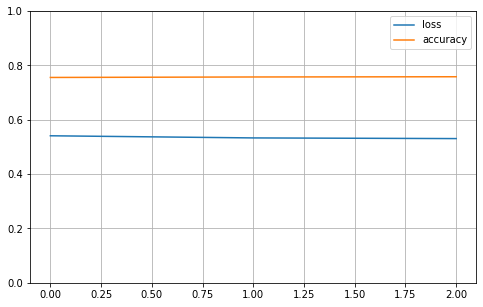

Train sizes (43698, 3997) (43698, 1)
Train set ones/size 32959 / 43698
Compute valiation accuracy
2023-01-18 22:50:22.329757
Valid sizes (10712, 3997) (10712, 1)
Valid set ones/size 7892 / 10712
Range of scores: 0.17049262 to 0.9811787
Predicted zeros and ones 567 10145
Accuracy: 74.11% Precision: 75.23% Recall: 96.71% F1: 84.63%
2023-01-18 22:50:26.531878
Fold 5
Training example
[169 163 140 ...   0   0   0]
BUILD MODEL
COMPILE
FIT
2023-01-18 22:50:34.980680
Epoch 1/3
1370/1370 [==============================] - 10s 6ms/step - loss: 0.5430 - accuracy: 0.7541
Epoch 2/3
1370/1370 [==============================] - 9s 6ms/step - loss: 0.5352 - accuracy: 0.7554
Epoch 3/3
1370/1370 [==============================] - 9s 6ms/step - loss: 0.5330 - accuracy: 0.7573
2023-01-18 22:51:02.535226


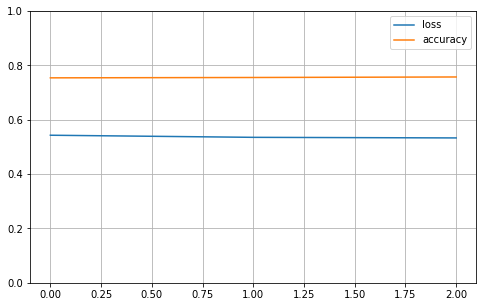

Train sizes (43817, 3997) (43817, 1)
Train set ones/size 33034 / 43817
Compute valiation accuracy
2023-01-18 22:51:03.906414
Valid sizes (10593, 3997) (10593, 1)
Valid set ones/size 7817 / 10593
Range of scores: 0.22406387 to 0.9748161
Predicted zeros and ones 380 10213
Accuracy: 74.81% Precision: 75.21% Recall: 98.26% F1: 85.20%
2023-01-18 22:51:07.789896

Cross validation 5 folds 3 epochs
 accuracy mean 75.35% +/- 0.88
 precision mean 76.21% +/- 0.86
 recall mean 97.63% +/- 0.62
 F1 mean 85.60% +/- 0.67
2023-01-18 22:51:07.793623


In [22]:
print(datetime.now())
cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
cv_accuracy, cv_precision, cv_recall, cv_f1 = cvdo.do_cross_validation()   
cvdo = None
print("Cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
print(" accuracy mean %.2f%% +/- %.2f" % (np.mean(cv_accuracy), np.std(cv_accuracy)))
print(" precision mean %.2f%% +/- %.2f" % (np.mean(cv_precision), np.std(cv_precision)))
print(" recall mean %.2f%% +/- %.2f" % (np.mean(cv_recall), np.std(cv_recall)))
print(" F1 mean %.2f%% +/- %.2f" % (np.mean(cv_f1), np.std(cv_f1)))
print(datetime.now())